In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from IPython.display import Latex


warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# Cox–Ingersoll–Ross model
#### In mathematical finance, the Cox–Ingersoll–Ross (CIR) model describes the evolution of interest rates. It is a type of "one factor model" (short-rate model) as it describes interest rate movements as driven by only one source of market risk. The model can be used in the valuation of interest rate derivatives.

# The Model
#### The CIR model describes the instantaneous interest rate $r_t$ whose stochastic differential equation is
### $dr_t = k(\theta - r_t )dt + \sigma\sqrt{r_t}dW_t$
#### $W_t$ is a wiener process, $k$ is the speed of the mean reversion
#### $\theta $ long time mean interest rate,  $\sigma > 0 $ is the volatility.

In [ ]:
google_ticker = "GOOG"
data = yf.download(google_ticker, start="2023-01-01", end="2024-01-01")
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,89.830002,91.550003,89.019997,89.699997,89.598038,20738500
2023-01-04,91.010002,91.239998,87.800003,88.709999,88.609169,27046500
2023-01-05,88.070000,88.209999,86.559998,86.769997,86.671371,23136100
2023-01-06,87.360001,88.470001,85.570000,88.160004,88.059799,26612600
2023-01-09,89.195000,90.830002,88.580002,88.800003,88.699066,22996700


In [ ]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,89.830002,91.550003,89.019997,89.699997,89.598038,20738500
2023-01-04,91.010002,91.239998,87.800003,88.709999,88.609169,27046500
2023-01-05,88.070000,88.209999,86.559998,86.769997,86.671371,23136100
2023-01-06,87.360001,88.470001,85.570000,88.160004,88.059799,26612600
2023-01-09,89.195000,90.830002,88.580002,88.800003,88.699066,22996700
...,...,...,...,...,...,...
2023-12-22,142.130005,143.250000,142.054993,142.720001,142.557770,18494700
2023-12-26,142.979996,143.945007,142.500000,142.820007,142.657669,11170100
2023-12-27,142.830002,143.320007,141.050995,141.440002,141.279236,17288400


In [ ]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


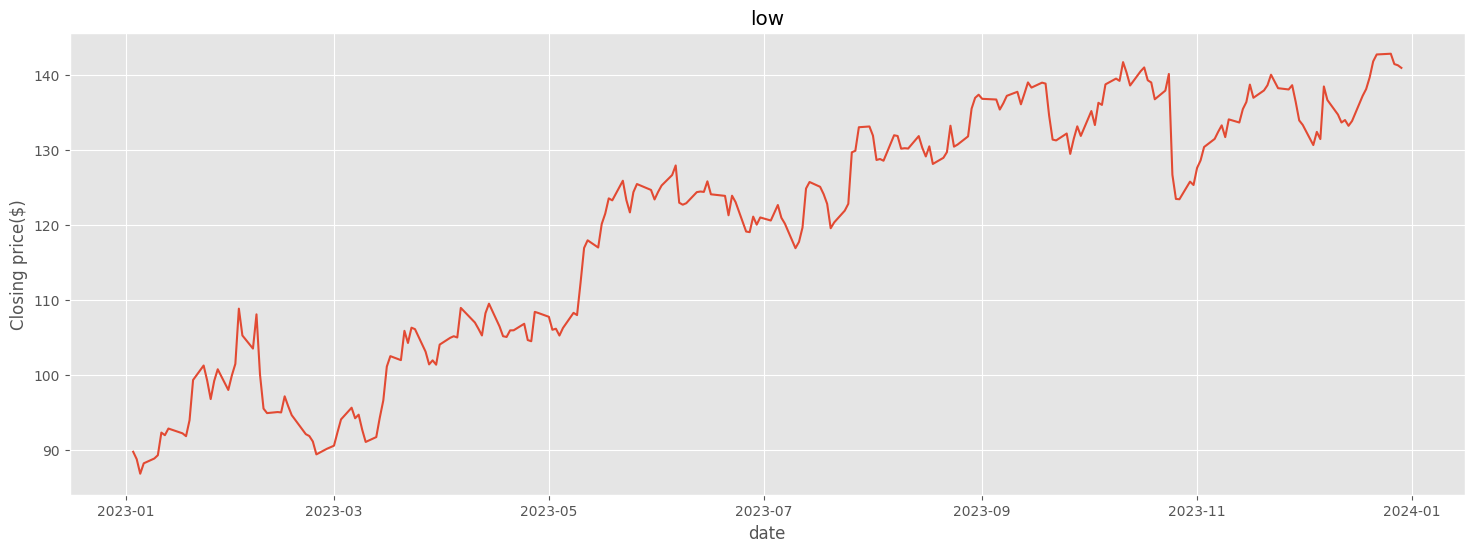

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(data.Close)
plt.ylabel("Closing price($)")
plt.xlabel("date")
plt.title("low")
plt.show()

In [ ]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,250.000000,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,119.353696,120.839552,118.241272,119.611860,119.475902,2.556214e+07
std,16.476135,16.425843,16.425004,16.373269,16.354658,1.085709e+07
min,86.720001,88.209999,85.570000,86.769997,86.671371,8.828600e+06
25%,105.252502,106.565001,104.262499,105.142502,105.022991,1.910105e+07
50%,123.954998,125.377499,122.775002,123.965000,123.824093,2.275790e+07
75%,133.205002,134.472496,132.113754,133.290001,133.138493,2.834745e+07
max,142.979996,143.945007,142.500000,142.820007,142.657669,9.779860e+07


## SDE discretization

### Model discretization using $\textbf{Euler-Maruyama}$  
### Euler - Maruyama is a numerical method that transforms the stochastic differential equation
### $dr_t = k(\theta - r_t)dt + \sigma\sqrt{r_t}dW_t$
### into discrete-time equation ;
### $r_{t+\Delta t} - r_k =  k(\theta - r_t)\delta t + \sigma\sqrt{r_t  \Delta t } \epsilon_t    $

### $\epsilon_t \sim N(0, \sigma^2), $, more precisely $\epsilon_t $ is a white noise process.

# Parameter Estimation using Ordinary Least squares.
### $r_{t+\Delta t} - r_t =  k(\theta - r_t)\delta t + \sigma\sqrt{r_t  \Delta t } \epsilon_t    $  

### the equation above can be transfromed into

### $\dfrac{r_{t+\Delta t}- r_t }{\sqrt{r_t}} = \dfrac{k\theta \Delta t}{\sqrt{r_t}} -  k \sqrt{r_t}\Delta t + \sigma \epsilon _t  $
### This can be interpreted as  
### $y_i =  \beta_{1}z_{1, i} + \beta_{2}z_{2, i} + \epsilon_i  $

### Where:
###      $ y_i =  \dfrac{r_{t+\Delta t} - r_t }{\sqrt{r_t}};  \quad \beta_{1} = k\theta; \quad \beta_{2} = -k; \quad \beta_{2} = -k ; \quad z_{1, i} = \dfrac{\Delta t}{\sqrt{r_t}}; \quad z_{2, i} = \sqrt{r_t}\Delta t  $

### Estimating the paraters, then
### $k = - \beta_2 ; \quad \theta = \dfrac{\beta}{k}; \quad  \sigma = \dfrac{var(\epsilon)}{\Delta t} $

In [ ]:


# function to find estimates using ols
def ols_estimates(data, dt):
    Nsteps = len(data)
    rs = data[:Nsteps-1]
    rt = data[1:Nsteps]

    # model initiallization
    model = LinearRegression(fit_intercept=False)


    y = (rt - rs) / np.sqrt(rs)
    z1 = dt/ np.sqrt(rs)
    z2 = dt * np.sqrt(rs)
    X = np.column_stack((z1, z2))

    model.fit(X, y)

    # calculate the predicted values (y_hat), residuals and the parameters
    y_hat = model.predict(X)
    residuals = y - y_hat
    beta1 = model.coef_[0]
    beta2 = model.coef_[1]

    # get the parameter of interest for CIR
    k0 = -beta2
    theta0 = beta1/k0
    sigma0 = np.std(residuals)/np.sqrt(dt)

    return k0, theta0, sigma0



In [ ]:

dt = 1 / 252
df = data["Close"] / 100
estimates = ols_estimates(df.values, dt)

# print results

print(f"The estimates are: k={round(estimates[0], 3)}, theta={round(estimates[1], 3)}, sigma={round(estimates[2], 3)}")

The estimates are: k=3.009, theta=1.368, sigma=0.327


In [ ]:

dt = 1 / len(data.Close)
df = data["Close"] / 100
estimates = ols_estimates(df.values, dt)

# print results

print(f"The estimates are: k={round(estimates[0], 3)}, theta={round(estimates[1], 3)}, sigma={round(estimates[2], 3)}")

The estimates are: k=2.985, theta=1.368, sigma=0.326


In [ ]:
k = round(estimates[0], 3)
theta = round(estimates[1], 3)
sigma = round(estimates[2], 3)

### Expected Value and Variance
### $\mathbb{E}[r_t | r_0] = r_0e^{-kt} + b(1-e^{-kt})$

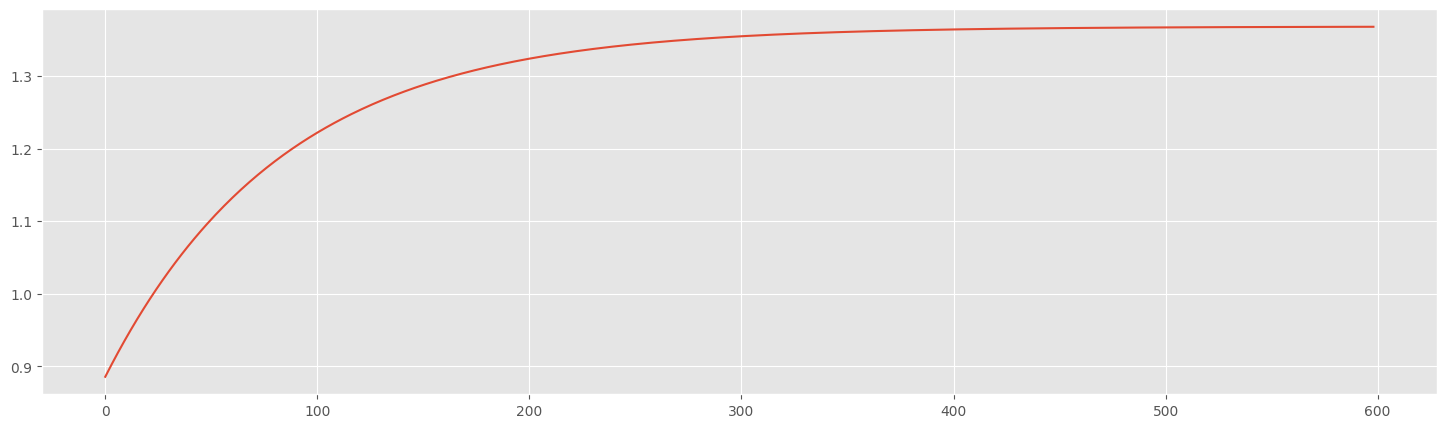

In [ ]:
r_start = 0.88
t = np.arange(1, 600, 1) / 252
#t = np.linspace(0, 400, 250)
ExpectedMean = r_start * np.exp(-k*t) + theta * (1 - np.exp(-k*t))
#print(ExpectedMean)
plt.figure(figsize=(18, 5))
plt.plot(ExpectedMean)
plt.show()

In [ ]:
### Monte Carlo Simulations

def simulate_cir(k, theta, sigma, r0, T, N):
    """
    params:
    k: float
        speed of mean-reversion
    theta: float
        long-run mean interest rate

    sigma: float
        volatility
    T: int
        time interval, eg days = 1

    N : int
        number of time steps

    """

    dt = T / N
    interest_rate_paths = np.zeros(N+1)
    interest_rate_paths[0] = r0

    for t in range(1, N+1):
        Z = np.random.randn()
        r = interest_rate_paths[t-1]
        interest_rate_paths[t] = r + k*(theta -r)* dt + sigma*np.sqrt(dt) * Z


    return interest_rate_paths


In [ ]:
k = 3.009
theta = 1.368
sigma = 0.327
r0 = df[0]
T = 1
N = len(df)


simulatedData = simulate_cir(k, theta, sigma, r0, T, N)
sim_df = pd.DataFrame(simulatedData)
sim_df.head()

,0
0,0.897000
1,0.891810
2,0.888029
3,0.887099
4,0.872953


In [ ]:
sim_df.describe()

,0
count,251.000000
mean,1.275686
std,0.217695
min,0.856764
25%,1.105750
50%,1.301453
75%,1.466426
max,1.611708


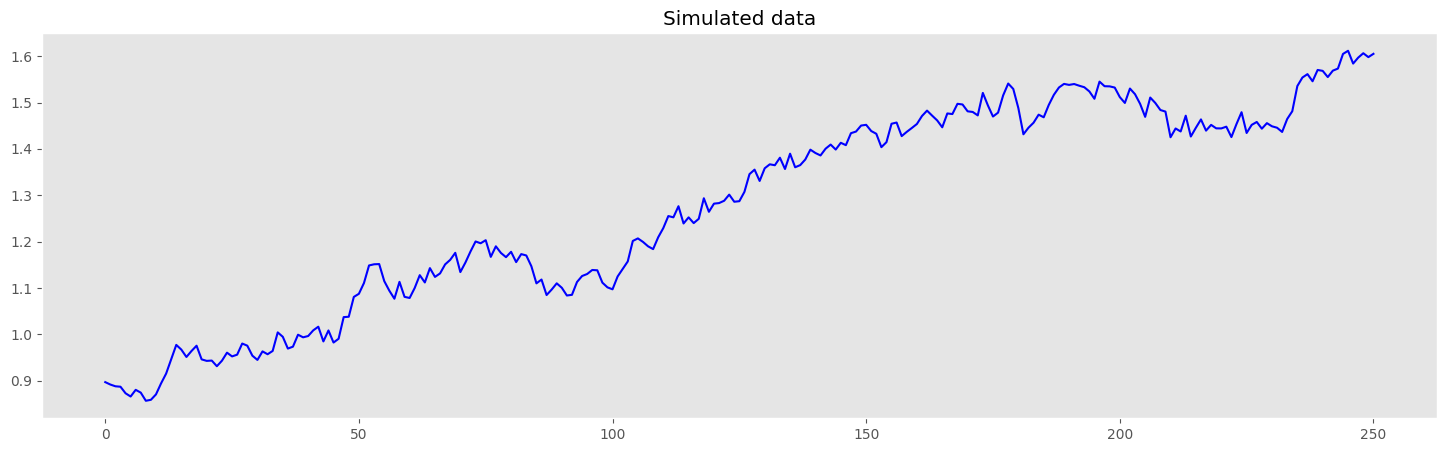

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(simulatedData, color="blue")
plt.grid()
plt.title("Simulated data")
plt.show()

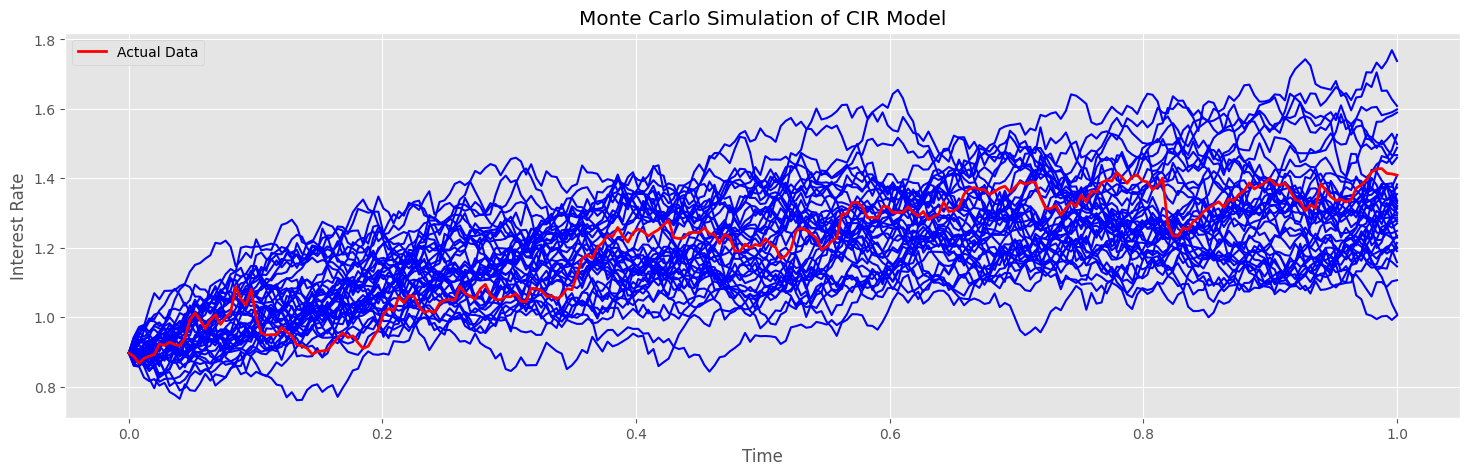

In [ ]:
plt.figure(figsize=(18, 5))

k = 3.009
theta = 1.368
sigma = 0.327
r0 = df[0]
T = 1
N = len(df)


T = 1.0  # time horizon
num_paths = 40 # number of Monte Carlo paths
num_steps = len(df) - 1 # number of time steps  250 steps

# Time discretization
dt = T / num_steps
sqrt_dt = np.sqrt(dt)

# Generate random numbers
np.random.seed(0)
dW = np.random.normal(loc=0, scale=sqrt_dt, size=(num_paths, num_steps))
#print(dW)
# Initialize rate paths
r = np.zeros((num_paths, num_steps + 1))
r[:, 0] = r0

# Simulate CIR process
for i in range(num_steps):
    r[:, i + 1] = r[:, i] + k * (theta - r[:, i]) * dt + sigma * np.sqrt(r[:, i]) * dW[:, i]

# Plot results
time_grid = np.linspace(0, T, num_steps + 1)
for i in range(num_paths):
    plt.plot(time_grid, r[i, :], color="blue")
plt.plot(time_grid, df, color='red', linewidth=2, label='Actual Data')
plt.xlabel('Time')
plt.ylabel('Interest Rate')
plt.title('Monte Carlo Simulation of CIR Model')
plt.legend()
plt.show()


### Measuring Forcasting Accuracy
####

In [ ]:
from sklearn import metrics

# simulate data and find the error between obeserved and
# actual data
T_new = 1
N_new = 249 # steps
sim_data = simulate_cir(k, theta, sigma, r0, T_new , N_new)
#print(len(sim_data), len(df))
preds = sim_data
real_data = data[["Close"]].values / 100
#print(real_data)
mse = round(metrics.mean_squared_error(real_data, preds), 6)

print(mse)

0.021111


In [ ]:
# simulate alot data and find the mse.